In [1]:
import re
import json

In [3]:
with open('data/Top10_Communities.json', encoding='utf-8-sig') as f:
    data = json.load(f)
    
with open('data/Conference_Id_name.json',encoding='utf-8-sig') as f:
    conference_data = json.load(f)

In [4]:
conference_data_dict = dict()
for conf_data in conference_data:
    conference_data_dict[conf_data['Id_Venue']] = conf_data['conference name']

conference_data_dict

{30: 'international conference of the ieee engineering in medicine and biology society',
 65: 'robot and human interactive communication',
 104: 'symposium on principles of database systems',
 122: 'acm sigplan symposium on principles and practice of parallel programming',
 208: 'mobile adhoc and sensor systems',
 235: 'international conference on computational linguistics',
 256: 'international conference on learning representations',
 293: 'passive and active network measurement',
 339: 'computer and communications security',
 343: 'hot topics in networks',
 344: 'conference of the european chapter of the association for computational linguistics',
 369: 'vehicular technology conference',
 374: 'european symposium on research in computer security',
 390: 'international symposium on biomedical imaging',
 422: 'knowledge discovery and data mining',
 507: 'international conference on management of data',
 517: 'international conference on software testing verification and validation',
 

In [5]:
import re
import random
import numpy as np
import pandas as pd 
from pprint import pprint
from collections import Counter, OrderedDict

import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.models.phrases import Phraser

import pyLDAvis
from pyLDAvis import gensim_models

from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import plotly.express as px


%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)  

stop_words = set(stopwords.words('english'))
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"
lmtzr = WordNetLemmatizer()

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


In [6]:
def color_func(**kwargs):
    return "hsl(0, {}%, 50%)".format(random.randint(0, 50))

In [7]:
papers = pd.DataFrame(data)
papers.dropna(inplace=True)
papers.head()

ID_Article  communityId  ID_RelatedVenue  \
0     2897211        21220               30   
1     2950694        21235               30   
2     2922123        21235               30   
3     2921960        21235               30   
4     2981319        21246               30   

                                               title  year  \
0  A wide range and high sensitivity four-channel...  2016   
1  Recent machine learning advancements in sensor...  2016   
2  Automatic grasp selection using a camera in a ...  2016   
3  Automatic tissue characterization of air trapp...  2016   
4  Unified phase variables of relative degree two...  2016   

                                            abstract  
0  We present a four-channel, high-sensitivity an...  
1  The development of wearable sensors has opened...  
2  In this paper, we demonstrate how automatic gr...  
3  Significant progress has been made in recent y...  
4  A starting point to achieve stable locomotion ...

In [8]:
papers['communityId'].value_counts()

21220    13607
21349    13468
21239    12344
22736    11616
21246    10947
21212    10306
20178    10049
21235     8606
22457     7875
21258     3506
Name: communityId, dtype: int64

In [9]:
# Input Community to perform analysis on
community_id_to_use = 21235

In [10]:
df = papers[papers['communityId'] == community_id_to_use]
df.head()

ID_Article  communityId  ID_RelatedVenue  \
1     2950694        21235               30   
2     2922123        21235               30   
3     2921960        21235               30   
5     2973656        21235               30   
6     2933639        21235               30   

                                               title  year  \
1  Recent machine learning advancements in sensor...  2016   
2  Automatic grasp selection using a camera in a ...  2016   
3  Automatic tissue characterization of air trapp...  2016   
5  Path-based connectivity for clustering genome ...  2016   
6  Unsupervised selection of RV144 HIV vaccine-in...  2016   

                                            abstract  
1  The development of wearable sensors has opened...  
2  In this paper, we demonstrate how automatic gr...  
3  Significant progress has been made in recent y...  
5  Clustering is an unsupervised data mining tool...  
6  HIV-1 vaccine injection has been shown less ef...

We will first take a look at the papers in the community disributed by the year they were published in and see if we can find any patterns in it. 

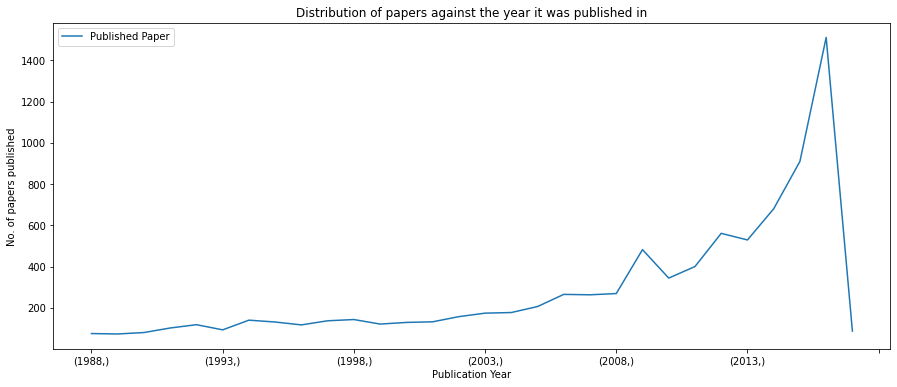

In [11]:
ax = df[['year']].sort_values(by='year').value_counts(sort=False).plot( 
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the year it was published in')
ax.set_xlabel('Publication Year')
ax.set_ylabel('No. of papers published')
plt.legend(["Published Paper"])

We see that most of the papers in the community were published in the years after 2004 with year 2011 accounting for the highest number of papers.

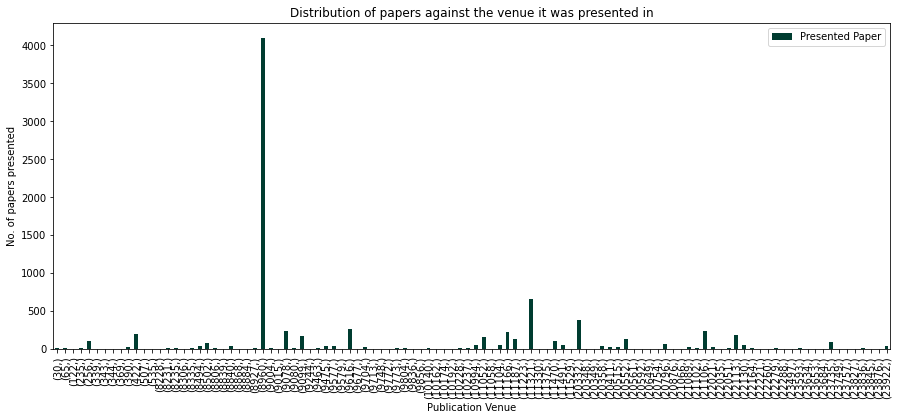

In [12]:
ax = df[['ID_RelatedVenue']].value_counts(sort=False).plot(kind='bar',colormap = 'BrBG_r',
                                                                       figsize=(15,6), 
                                                                       title='Distribution of papers against the venue it was presented in')
ax.set_xlabel('Publication Venue')
ax.set_ylabel('No. of papers presented')
plt.legend(["Presented Paper"])

In [44]:
conference_data_dict[8960]

'neural information processing systems'

Venue of conferences are more spread out across this community, However, most of the papers still were presented in one conference (with conferenceId 8960) **Neural Information Processing Systems**.We should be expecting papers about neural networks and mew algorithms in this comference.

In [14]:
plot_df = pd.DataFrame()

## Analyzing the title of the papers

We will initially plot a wordcloud of the 1000 most used terms in the titles of the papers of the community and see which are the most commonly used words in the titles of the papers

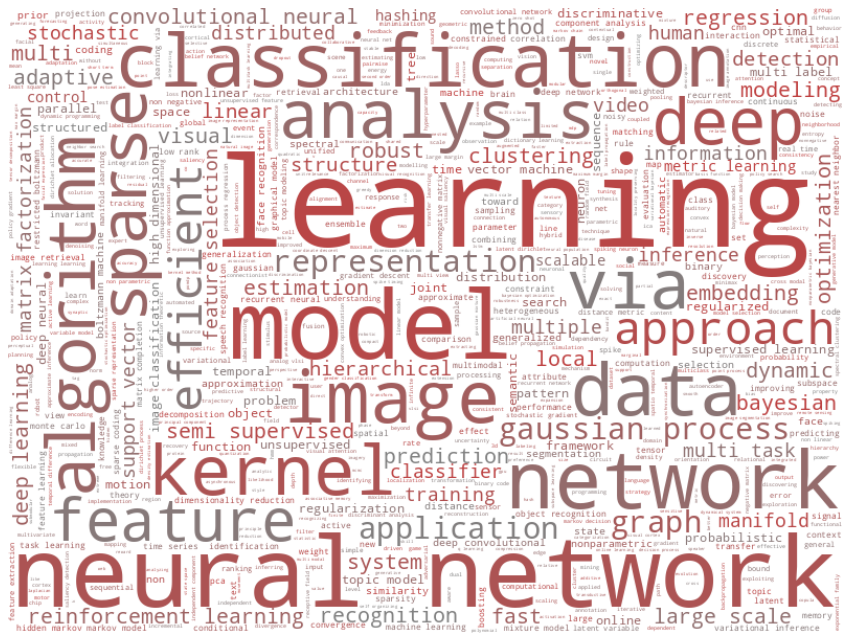

In [15]:
stop_words.update(['based', 'using', 'A', 'The'])

plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['title'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)
all_titles = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_titles)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

Looking at the wordcloud, we can see that a lot of papers of the community focus on images and videos models and algorithms. Since most papers of the community were presented at a conference about image processing, the results definitely are what we expect it to be like. Next we take a look at top 30 words and the number of times they have been used in the paper titles.

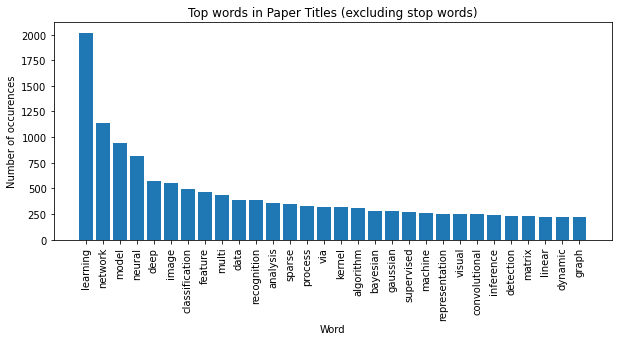

In [16]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])


count_vectorizer = CountVectorizer(stop_words=stop_words)
words, word_values = get_top_n_words(n_top_words=30,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=plot_df['col'])

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in Paper Titles (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Top words in the paper titles are about neural networks and models. Considering most papers are about , the results are consistent.

We apply Latent Discriminant Analysis (LDA) for topic modelling using only the titles of the papers

In [17]:
dictionary = corpora.Dictionary(plot_df['tokenized_col'])
texts = plot_df['tokenized_col']
corpus = [dictionary.doc2bow(text) for text in plot_df['tokenized_col']]

In [18]:
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [19]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [20]:
lda.show_topics(total_topics,6)

[(0,
  '0.047*"network" + 0.034*"learning" + 0.031*"deep" + 0.022*"neural" + 0.019*"image" + 0.017*"feature"'),
 (1,
  '0.022*"sparse" + 0.020*"learning" + 0.017*"regularization" + 0.016*"information" + 0.015*"matrix" + 0.013*"time"'),
 (2,
  '0.056*"network" + 0.046*"neural" + 0.033*"deep" + 0.033*"convolutional" + 0.024*"visual" + 0.023*"learning"'),
 (3,
  '0.039*"topic" + 0.039*"model" + 0.033*"analysis" + 0.022*"policy" + 0.016*"decomposition" + 0.014*"markov"'),
 (4,
  '0.041*"learning" + 0.025*"network" + 0.017*"object" + 0.015*"unsupervised" + 0.014*"recognition" + 0.014*"neural"'),
 (5,
  '0.070*"learning" + 0.033*"supervised" + 0.027*"semi" + 0.023*"image" + 0.019*"classification" + 0.016*"metric"'),
 (6,
  '0.076*"learning" + 0.025*"task" + 0.023*"vector" + 0.021*"multi" + 0.019*"support" + 0.019*"reinforcement"'),
 (7,
  '0.034*"learning" + 0.033*"label" + 0.026*"multi" + 0.017*"matrix" + 0.017*"kernel" + 0.016*"analysis"'),
 (8,
  '0.052*"process" + 0.045*"gaussian" + 0.02

The above list of tuples show which terms are most important to which topic. The numbers attached to each term represents the weightages given to that term for the corresponding topic.

In [21]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

network  learning      deep    neural     image   feature      fpga  \
0  0.046996  0.034314  0.030602  0.022231  0.019043  0.017113  0.014274   
1  0.011258  0.019863  0.000000  0.009177  0.000000  0.000000  0.000000   
2  0.055647  0.023349  0.033264  0.045976  0.015215  0.017451  0.000000   
3  0.000000  0.012693  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.024877  0.041249  0.000000  0.013540  0.009442  0.013333  0.000000   
5  0.000000  0.069605  0.000000  0.000000  0.022547  0.000000  0.000000   
6  0.000000  0.076297  0.012076  0.000000  0.012029  0.008218  0.000000   
7  0.000000  0.034152  0.000000  0.000000  0.000000  0.014105  0.000000   
8  0.015649  0.012481  0.008184  0.012945  0.000000  0.000000  0.000000   
9  0.000000  0.047361  0.009016  0.000000  0.000000  0.000000  0.000000   

   recognition     aware  convolutional  ...     least    memory  inference  \
0     0.012921  0.011727       0.011313  ...  0.000000  0.000000   0.000000   
1     0.008139  0.000000       0.000000  ...  0.000000  0.000000   0.000000   
2     0.014943  0.000000       0.032537  ...  0.000000  0.000000   0.000000   
3     0.000000  0.000000       0.000000  ...  0.000000  0.000000   0.000000   
4     0.013974  0.000000       0.000000  ...  0.000000  0.000000   0.000000   
5     0.000000  0.000000       0.000000  ...  0.000000  0.000000   0.000000   
6     0.000000  0.000000       0.000000  ...  0.000000  0.000000   0.000000   
7     0.000000  0.000000       0.000000  ...  0.000000  0.000000   0.000000   
8     0.000000  0.000000       0.000000  ...  0.007118  0.006641   0.000000   
9     0.026522  0.000000       0.000000  ...  0.000000  0.000000   0.017165   

   saliency  variational    facial    sensor      view  structure  activity  
0  0.000000     0.000000  0.000000  0.000000  0.000000   0.000000  0.000000  
1  0.000000     0.000000  0.000000  0.000000  0.000000   0.000000  0.000000  
2  0.000000     0.000000  0.000000  0.000000  0.000000   0.000000  0.000000  
3  0.000000     0.000000  0.000000  0.000000  0.000000   0.000000  0.000000  
4  0.000000     0.000000  0.000000  0.000000  0.000000   0.000000  0.000000  
5  0.000000     0.000000  0.000000  0.000000  0.000000   0.000000  0.000000  
6  0.000000     0.000000  0.000000  0.000000  0.000000   0.000000  0.000000  
7  0.000000     0.000000  0.000000  0.000000  0.000000   0.000000  0.000000  
8  0.000000     0.000000  0.000000  0.000000  0.000000   0.000000  0.000000  
9  0.011941     0.010506  0.010469  0.009616  0.009584   0.007131  0.006639  

[10 rows x 159 columns]

The score for each term in the above dataframe denotes how important that term is to the topic which is represented from numbers 0 to 9. A higher score of a term in a particular topic row indicates that that term is of high importance to that topic.

Next, we will plot a heatmap representing the similarities and correlations between terms present in the titles of the different papers. This allows us to see which words or terms are highly correlated and which are not. A darker shade of red between two terms represents that they are very highly correlated with one another.

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


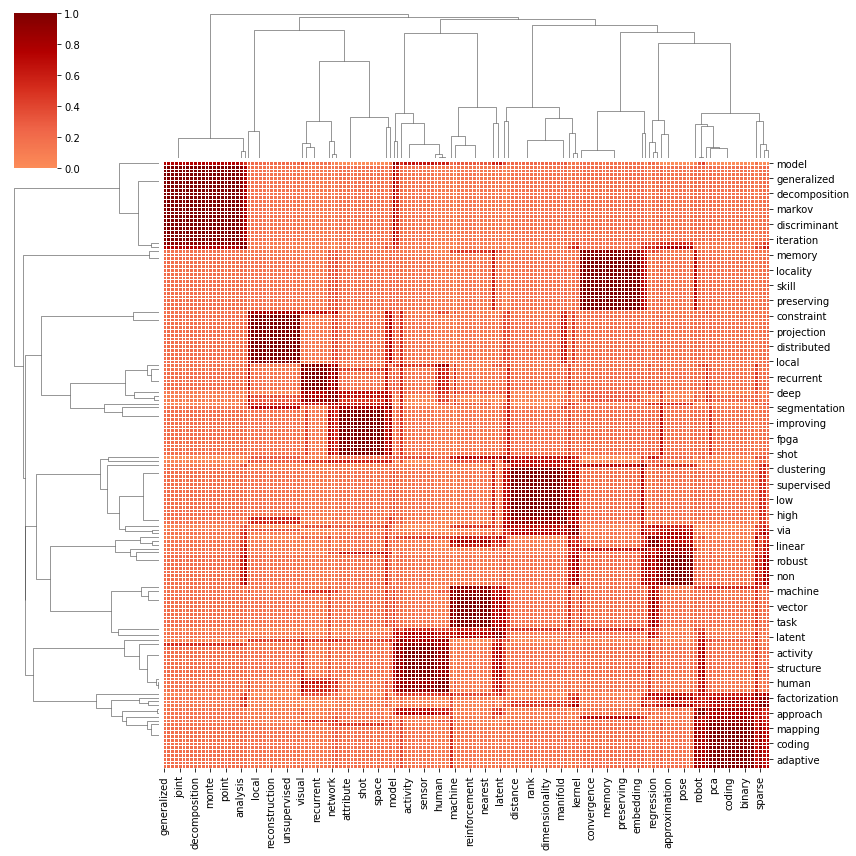

In [22]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [23]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      32.420952   8.115230       1        1  30.587682
4       0.648955  71.707100       2        1  10.099850
0      71.019684   9.971006       3        1   9.645370
9       3.785981  33.185135       4        1   9.560858
3     -42.666500  -9.222070       5        1   9.308600
6      -3.621689 -43.526516       6        1   8.871134
1      -3.632402  -4.171708       7        1   6.267499
5     -36.584400  35.804413       8        1   5.307212
7      44.391380  50.615383       9        1   5.189595
8      40.235809 -31.591665      10        1   5.162199, topic_info=         Term        Freq       Total Category  logprob  loglift
6    learning  296.000000  296.000000  Default  30.0000  30.0000
485     topic   45.000000   45.000000  Default  29.0000  29.0000
309   process   37.000000   37.000000  Default  28.0000  28.0000
21    network  232.000000  232.000000  Default  27.0000  27.0000
308  gaussian   33.000000   33.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
476     large    3.197635   33.331451  Topic10  -4.9340   0.6197
56   adaptive    2.698091   21.752270  Topic10  -5.1039   0.8766
4        deep    3.635812  143.022187  Topic10  -4.8056  -0.7084
226     model    3.378189  128.823076  Topic10  -4.8791  -0.6773
892     point    2.448295   13.776423  Topic10  -5.2010   1.2362

[672 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2732      9  0.819221           2d
1281      1  0.889344           3d
1281      2  0.068411           3d
1025      8  1.115907  abstraction
253       9  0.724017  accelerated
...     ...       ...          ...
2541      5  1.217364        whole
814       9  1.135520         wild
413       3  0.921784         wise
1868      7  0.547670        world
326       3  0.942973         zero

[1198 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 10, 4, 7, 2, 6, 8, 9])

The above plot is a 2D mapped visualization of the distances between each of the generated topics through LDA. Hovering the mouse above a particular circle (which represents a topic) allows us to see important terms and words that make up that topic.

NOTE: Relevance is denoted by λ, the weight assigned to the probability of a term in a topic relative to its lift. When λ = 1, the terms are ranked by their probabilities within the topic (the ‘regular’ method) while when λ = 0, the terms are ranked only by their lift. Lift is the ratio of a term’s probability within a topic to its margin probability across the corpus.

Next we will take a look at some of the paper titles with maximum correspondence to the top topic words.

In [24]:
titles = plot_df['col'].values

count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(titles)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [25]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [26]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  learning, supervised, model, kernel, classification, data, semi, feature, analysis, algorithm, sparse, graph, manifold, metric, vector

Paper Titles:
Non-linear regression for bag-of-words data via gaussian process latent variable set model
Unsupervised Joint Mining of Deep Features and Image Labels for Large-Scale Radiology Image Categorization and Scene Recognition
Combining stochastic average gradient and Hessian-free optimization for sequence training of deep neural networks
Spectral Clustering for Large-Scale Social Networks via a Pre-Coarsening Sampling based NystrÖm Method

****************************************************************************************************
TOPIC 1:
Top Words:  factorization, matrix, nonnegative, ranking, pooling, autoencoders, bounded, synchronization, invariance, operator, target, autoregressive, hmms, sorting, ica

Paper Titles:
SerialRank: Spectral Ranking using Seriation
Ladder Variational Autoencoders
Spectral Ranking u

## Analyzing the abstracts of the papers

In [27]:
# stop_words.update(['based', 'using', 'A', 'The'])
latex_regex = r"(\$+)(?:(?!\1)[\s\S])*\1"

## Cleaning the text of the abstract to remove or ignore unimportant symbols and characters
plot_df['tokenized_col'] = df.apply(lambda row: (re.sub("[^A-Za-z0-9' ]+", ' ', row['abstract'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (re.sub(latex_regex, "", row['tokenized_col'])),axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: row['tokenized_col'].lower(), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: (word_tokenize(row['tokenized_col'])), axis = 1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([w for w in row['tokenized_col'] if w not in stop_words]), axis=1)
plot_df['tokenized_col'] = plot_df.apply(lambda row: ([lmtzr.lemmatize(w) for w in row['tokenized_col']]), axis=1)
plot_df['col'] = plot_df.apply(lambda row: ' '.join(row['tokenized_col']), axis=1)

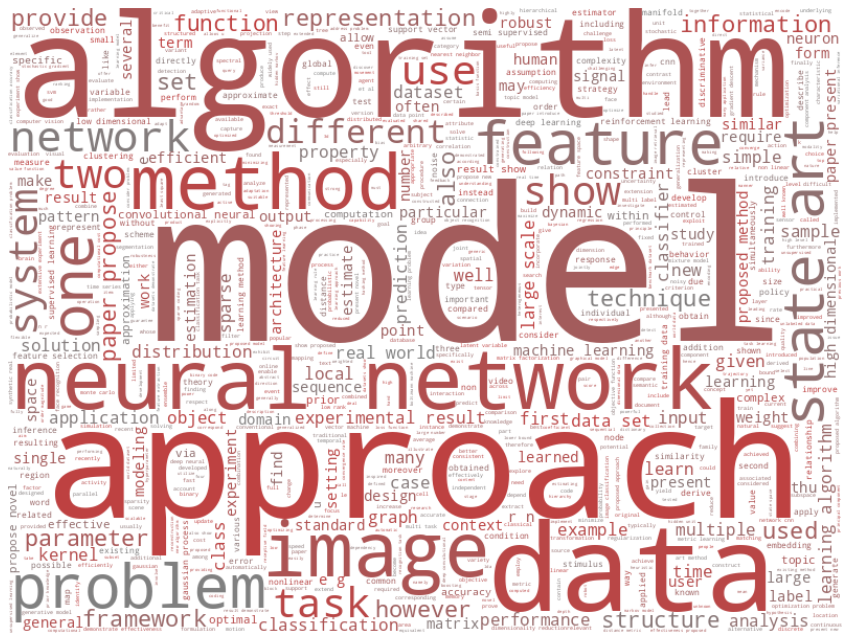

In [28]:
all_abstracts = ' '.join(plot_df['col'].str.lower())

wordcloud = WordCloud(stopwords=stop_words, background_color="white", 
                      max_words=1000, width=800, height=600).generate(all_abstracts)
default_colors = wordcloud.to_array() #convert to array for recoloring

rcParams['figure.figsize'] = 15, 25
plt.imshow(wordcloud.recolor(color_func=color_func), #apply recoloring using color function
           interpolation="bilinear")
plt.axis("off")
plt.show()

As expected, the word cloud from abstracts of the papers are pretty similar to that of the titles with pretty much the same words having higher frequencies of occurences in the abstracts.

### Ngram Analysis of Abstracts

In [29]:
def count_ngrams(dataframe,column,begin_ngram,end_ngram): 
    word_vectorizer = CountVectorizer(ngram_range=(begin_ngram,end_ngram), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(dataframe[column].dropna())
    frequencies = sum(sparse_matrix).toarray()[0]
    most_common = pd.DataFrame(frequencies, 
                               index=word_vectorizer.get_feature_names(), 
                               columns=['frequency']).sort_values('frequency',ascending=False)
    most_common['ngram'] = most_common.index
    most_common.reset_index()
    return most_common

def word_cloud_function(df,column,number_of_words):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    word_string=str(popular_words_nonstop)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=number_of_words,
                          width=1000,height=1000,
                         ).generate(word_string)
    plt.clf()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def word_bar_graph_function(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

In [30]:
two_grams = count_ngrams(plot_df,'col',2, 2)

fig = px.bar(two_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 2-Words in Abstracts of Papers',
             orientation='h')
fig.show()

In [31]:
three_grams = count_ngrams(plot_df,'col',3, 3)

fig = px.bar(three_grams.sort_values('frequency',ascending=False)[0:10].iloc[::-1], 
             x="frequency", 
             y="ngram",
             title='Most Common 3-Words in Abstracts of Papers',
             orientation='h')
fig.show()

For abstract, instead of using single words for topic modelling, we will be using ngrams in the range of [1,3]. Through this way, we should be able to capture more context from the abstract texts of the papers.

In [32]:
ngrams = Phrases(plot_df['tokenized_col'].values, min_count=1, threshold=3, delimiter=' ')

ngrams_phraser = Phraser(ngrams)

ngram_token = []
for sent in plot_df['tokenized_col'].values:
    ngram_token.append(ngrams_phraser[sent])

In [33]:
dictionary = corpora.Dictionary(ngram_token)
corpus = [dictionary.doc2bow(text) for text in ngram_token]

tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [34]:
total_topics = 10

lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tf

In [35]:
lda.show_topics(total_topics, 7)

[(0,
  '0.013*"model" + 0.011*"method" + 0.011*"learning" + 0.010*"algorithm" + 0.009*"image" + 0.007*"data" + 0.007*"feature"'),
 (1,
  '0.012*"algorithm" + 0.008*"problem" + 0.007*"method" + 0.006*"model" + 0.006*"learning" + 0.004*"result" + 0.004*"function"'),
 (2,
  '0.012*"method" + 0.008*"classification" + 0.008*"approach" + 0.006*"classifier" + 0.005*"learning" + 0.005*"task" + 0.005*"problem"'),
 (3,
  '0.015*"method" + 0.013*"data" + 0.013*"network" + 0.012*"model" + 0.009*"problem" + 0.009*"algorithm" + 0.008*"learning"'),
 (4,
  '0.015*"data" + 0.012*"method" + 0.010*"model" + 0.009*"algorithm" + 0.008*"approach" + 0.008*"feature" + 0.007*"learning"'),
 (5,
  '0.016*"model" + 0.012*"problem" + 0.011*"learning" + 0.010*"task" + 0.009*"data" + 0.009*"approach" + 0.008*"feature"'),
 (6,
  '0.031*"model" + 0.014*"topic" + 0.006*"topic model" + 0.005*"method" + 0.004*"data" + 0.004*"distribution" + 0.004*"approach"'),
 (7,
  '0.006*"intel xeon" + 0.004*"mouth" + 0.004*"model" + 

In [36]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

model    method  learning  algorithm     image      data   feature  \
0  0.012888  0.011076  0.010896   0.010131  0.009201  0.007002  0.006638   
1  0.006111  0.006899  0.005549   0.011805  0.000000  0.002856  0.000000   
2  0.003282  0.011992  0.005176   0.000000  0.002973  0.003646  0.004428   
3  0.012325  0.015168  0.008330   0.008689  0.000000  0.013264  0.000000   
4  0.009937  0.012068  0.006932   0.009142  0.000000  0.015495  0.007637   
5  0.016053  0.006950  0.011476   0.007855  0.002917  0.009309  0.007908   
6  0.030588  0.005429  0.003028   0.000000  0.003448  0.004286  0.003028   
7  0.003846  0.002322  0.000000   0.001937  0.000000  0.000000  0.000000   
8  0.006102  0.001964  0.005891   0.002885  0.000000  0.003355  0.000000   
9  0.015955  0.007304  0.005766   0.005086  0.002685  0.003702  0.002817   

   approach    system      show  ...  natural gradient      psrs     bound  \
0  0.005452  0.005004  0.004894  ...          0.000000  0.000000  0.000000   
1  0.002528  0.000000  0.003912  ...          0.000000  0.000000  0.000000   
2  0.007723  0.000000  0.002685  ...          0.000000  0.000000  0.000000   
3  0.003942  0.000000  0.004909  ...          0.000000  0.000000  0.000000   
4  0.007710  0.000000  0.004150  ...          0.000000  0.000000  0.000000   
5  0.008909  0.000000  0.006267  ...          0.000000  0.000000  0.000000   
6  0.004010  0.000000  0.003585  ...          0.000000  0.000000  0.000000   
7  0.000000  0.000000  0.002852  ...          0.000000  0.000000  0.000000   
8  0.002844  0.000000  0.003666  ...          0.001804  0.001733  0.001714   
9  0.004506  0.000000  0.003971  ...          0.000000  0.000000  0.000000   

     linear   density     class         1         2  estimate    filter  
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
5  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
6  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
7  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
8  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
9  0.002834  0.002756  0.002739  0.002498  0.002342  0.002263  0.002256  

[10 rows x 111 columns]

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



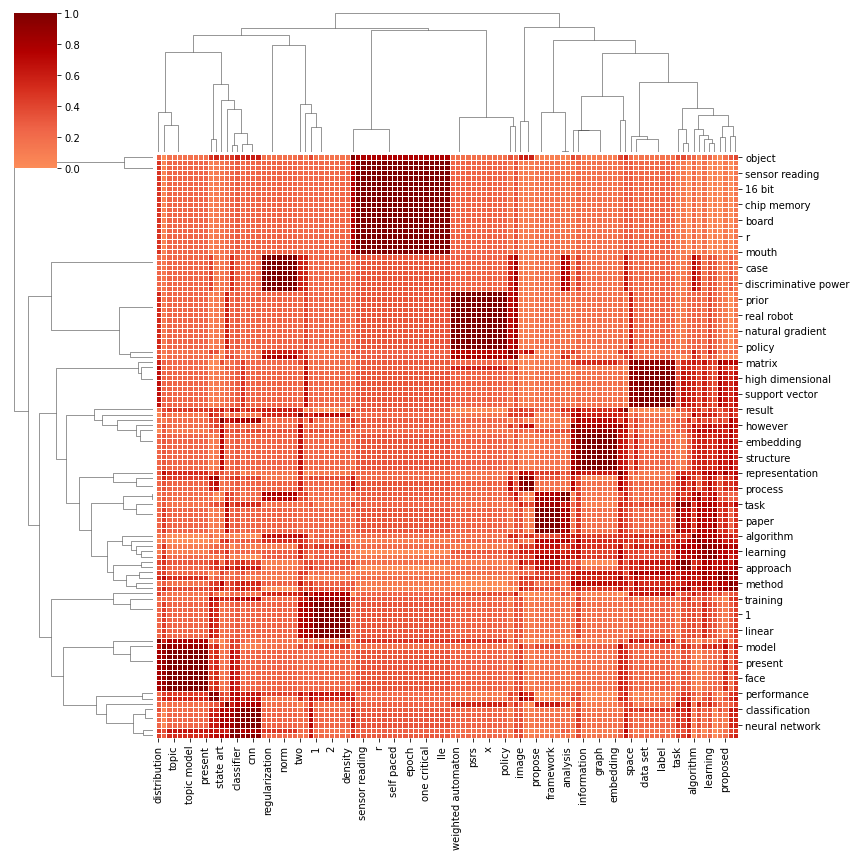

In [37]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="OrRd", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [38]:
pyLDAvis.enable_notebook()
panel = gensim_models.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/home/bikram/anaconda3/envs/alt/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning:

'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.



PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  26.975862
3       0.648955  71.707100       2        1  12.393615
2      71.019684   9.971006       3        1  10.679669
5       3.785981  33.185135       4        1   8.547730
1     -42.666500  -9.222070       5        1   8.315282
4      -3.621689 -43.526516       6        1   8.021854
6      -3.632402  -4.171708       7        1   6.282352
9     -36.584400  35.804413       8        1   6.266511
8      44.391380  50.615383       9        1   6.258962
7      40.235809 -31.591665      10        1   6.258162, topic_info=              Term       Freq      Total Category  logprob  loglift
262          model  99.000000  99.000000  Default  30.0000  30.0000
1323         topic  10.000000  10.000000  Default  29.0000  29.0000
15            data  60.000000  60.000000  Default  28.0000  28.0000
45         network  34.000000  34.000000  Default  27.0000  27.0000
152        problem  47.000000  47.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
38          method   1.250636  80.477503  Topic10  -6.0653  -1.3930
348   distribution   0.898919  13.808634  Topic10  -6.3955   0.0394
2        algorithm   1.043147  61.779432  Topic10  -6.2467  -1.3100
277         result   0.810403  27.182362  Topic10  -6.4991  -0.7415
89           image   0.707859  34.402273  Topic10  -6.6344  -1.1123

[795 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
330       1  0.371870     1
330       2  0.092968     1
330       3  0.092968     1
330       4  0.092968     1
330       5  0.092968     1
...     ...       ...   ...
402       4  0.154027  well
402       5  0.077013  well
402       6  0.077013  well
402       7  0.077013  well
1624      9  0.359719     x

[919 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 6, 2, 5, 7, 10, 9, 8])

In [39]:
abstracts = plot_df['col'].values

count_vectorizer = CountVectorizer(ngram_range=(1,3))
counts = count_vectorizer.fit_transform(abstracts)
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf_abstracts = tfidf_vectorizer.transform(counts)

In [40]:
lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_abstracts)
lda_W = lda_model.transform(tfidf_abstracts)
lda_H = lda_model.components_

In [41]:
def display_topics(H, W, feature_names, title_list, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("TOPIC %d:" % (topic_idx))
        print("Top Words: ",", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        print()
        print("Paper Titles:")
        for doc_index in top_doc_indices:
            print(title_list[doc_index])
        print()
        print('*' * 100)
            
no_top_words = 15
no_top_documents = 4     
title_list = df['title'].tolist()
tf_feature_names = count_vectorizer.get_feature_names()
display_topics(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)

TOPIC 0:
Top Words:  recruitment, rgp, british machine, september 2013 bristol, bmvc, 24th, 2013 13, 24th british machine, bmvc 2013, 24th british, bristol, conference bmvc 2013, 2013 bristol, presented 24th british, september 2013

Paper Titles:
An In Depth View of Saliency.
Prioritizing disease genes by bi-random walk
Targeted Topic Modeling for Focused Analysis
Recruitment Market Trend Analysis with Sequential Latent Variable Models

****************************************************************************************************
TOPIC 1:
Top Words:  type adversary, word probability distribution, secondary user, word probability, deep rnn, dnn representation, show negative, show negative bias, result hidden, negative bias, game framework, multiple type adversary, coalesced, floating point data, partial sum

Paper Titles:
Understanding the GPU Microarchitecture to Achieve Bare-Metal Performance Tuning
Reinforcement Learning Based Auction Algorithm for Dynamic Spectrum Access in Co

In [42]:
def get_representative_papers(H, W, feature_names, title_list, no_top_words, no_top_documents):
    representative_df = pd.DataFrame()
    for topic_idx, topic in enumerate(H):
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            representative_df = representative_df.append(df.iloc[doc_index])
    return representative_df
            
no_top_words = 30
no_top_documents = 350     
tf_feature_names = count_vectorizer.get_feature_names()
representative_df = get_representative_papers(lda_H, lda_W, tf_feature_names, title_list, no_top_words, no_top_documents)
representative_df.drop_duplicates(inplace=True)
for col in ['ID_Article', 'communityId', 'ID_RelatedVenue', 'year']:
    representative_df[col] = representative_df[col].astype('int')

In [43]:
representative_df.to_csv("CSV_files/repr_21235.csv", index=False)
representative_df

ID_Article  communityId  ID_RelatedVenue  \
105548      815672        21235            22130   
10103       519240        21235              422   
9942       2766566        21235              422   
9911       2845693        21235              422   
325        2586523        21235              256   
...            ...          ...              ...   
301        2633759        21235              256   
334        2554343        21235              256   
352        1311048        21235              256   
703        2885958        21235              369   
9948       2664397        21235              422   

                                                    title  year  \
105548                      An In Depth View of Saliency.  2013   
10103        Prioritizing disease genes by bi-random walk  2012   
9942         Targeted Topic Modeling for Focused Analysis  2016   
9911    Recruitment Market Trend Analysis with Sequent...  2016   
325                          Recurrent Gaussian Processes  2016   
...                                                   ...   ...   
301     A Test of Relative Similarity For Model Select...  2016   
334     Reducing Overfitting in Deep Networks by Decor...  2016   
352     On the number of inference regions of deep fee...  2014   
703     Frequency Selective Convolutional Neural Netwo...  2016   
9948                              Evolutionary clustering  2006   

                                                 abstract  
105548  Presented at the 24th British Machine Vision C...  
10103   Random walk methods have been successfully app...  
9942    One of the overarching tasks of document analy...  
9911    Recruitment market analysis provides valuable ...  
325     Abstract: We define Recurrent Gaussian Process...  
...                                                   ...  
301     Abstract: Probabilistic generative models prov...  
334     Abstract: One major challenge in training Deep...  
352     Abstract: This paper explores the complexity o...  
703     Image recognition, especially traffic sign rec...  
9948    We consider the problem of clustering data ove...  

[893 rows x 6 columns]